#### About this repository:

The notebooks in this repository are meant to serve as comprehensive building blocks for establishing an algorithmic trading system. 
 
A number of sample trading strategies are included, along with methodologies to determine their robustness. Walk-Forward Analysis is one such well known technique, while Combinatorial Purged Cross Validation is a newer and more  rigorous methodology. Another useful and important concept is Meta Labelling, which predicts the probability of individual winning trades. All three techniques are utilized here to help improve the rigor of the systematic trading research process. 

Even though the methodologies presented in these notebooks can always be fine-tuned further, they are sophisticated enough to provide rigorous backtesting of any algorithmic trading strategy. After looking through this repository, one should gain an understanding of how algorithmic trading startegies are programmed and backtested. Identifying such strategies can simply be a matter of adapting algorithms found in research journals or trading websites; the aim of these notebooks is to determine a strategy's profitability and robustness. The final step of live trading a strategy should be merely trivial rewriting of a few lines of code in the Zipline version of the strategy. 


*Hoa Tuan Nguyen:* http://linkedin.com/in/hoatuannguyen/

## Mean Reversion with Bollinger Bands  Strategy

This strategy was created to capture the type of largely sideways market we had in April and June 2020 for BTC. It uses Bollinger-bands indicators. 

The slow moving average will be optimized over a period of a few days, the fast moving average over the last couple of hours. The upper and lower bands are slow mva + - multiplier * slow std.

When the fast mva price breaches either the upper or lower band, the upper or lower-breached flag is switched on. When this fast mva comes back within the bands, we put on the corresponding short or long trade.

We take profit when the fast mva reaches the slow mva or if the unrealized profit is 4% or higher. We stop our losses when the unrealized loss surpasses 1.5%. These two parameters can also be optimized to a certain extent.

A couple data points are kept track of to help make sure the algorithm works as expected.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set_style('ticks')
%matplotlib inline

import optuna
import empyrical

In [2]:
df = pd.read_csv('data/btc_2019_aug6_2020.csv', index_col=0, parse_dates=True)

In [3]:
df.head()

,close,high,low,open,volume
2019-01-01 00:00:00+00:00,3694.5,3694.5,3693.0,3693.0,241.351087
2019-01-01 00:01:00+00:00,3690.5,3694.5,3690.5,3694.5,178.451678
2019-01-01 00:02:00+00:00,3690.5,3691.0,3690.5,3690.5,53.144116
2019-01-01 00:03:00+00:00,3690.0,3691.0,3690.0,3690.5,71.344447
2019-01-01 00:04:00+00:00,3688.5,3690.5,3688.5,3690.5,194.159810


In [4]:
sma_short = df.close.rolling(180).mean()
sma_long = df.close.rolling(1440).mean()
std_long = df.close.rolling(1440).std()

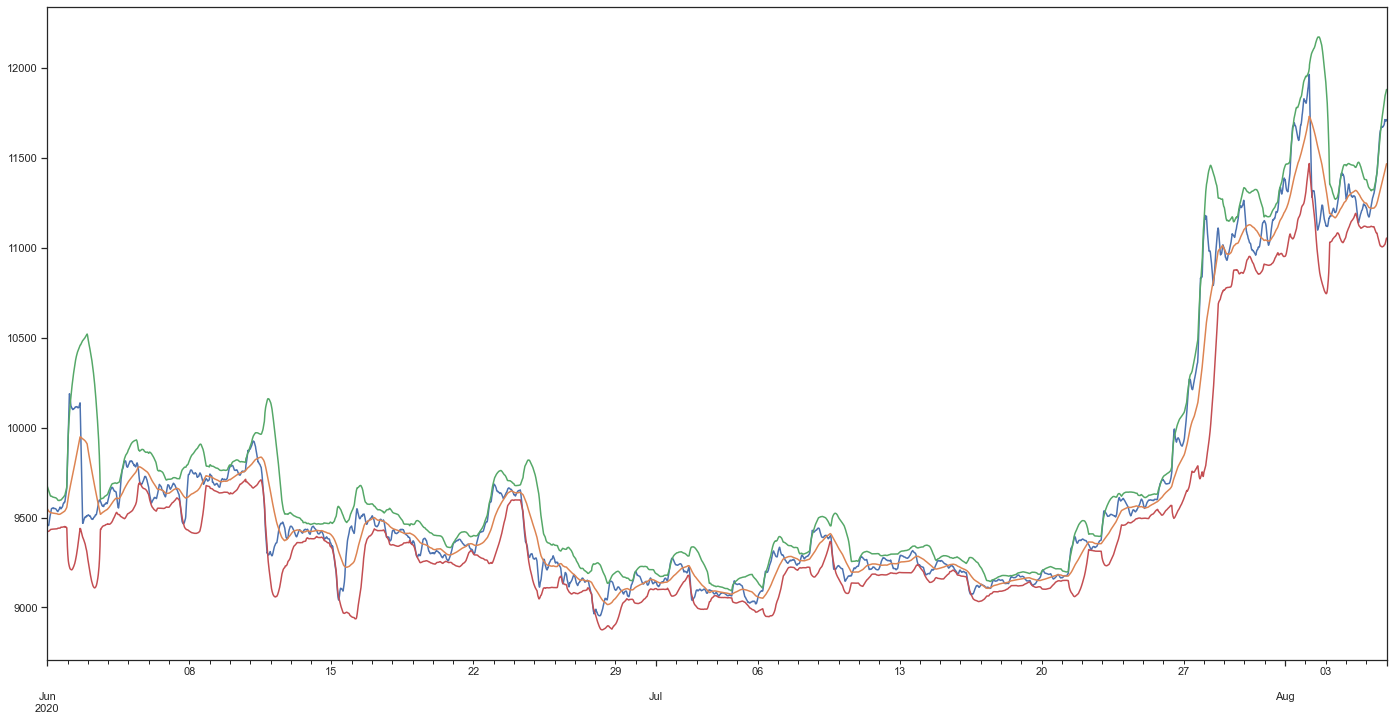

In [5]:
sma_short.loc['2020-06-01':].plot(figsize=(24,12))
sma_long.loc['2020-06-01':].plot()
(sma_long+2*std_long).loc['2020-06-01':].plot()
(sma_long-2*std_long).loc['2020-06-01':].plot()

In [6]:
# helper function to calculate Pessimistic Return on Margin from a cumulative return pandas series

def PROM(cumRet):
    trade_rets = cumRet-cumRet.shift(1).fillna(1)
    win_trades = trade_rets[trade_rets>0]
    lose_trades = trade_rets[trade_rets<0]
    adj_wins = len(win_trades) - np.sqrt(len(win_trades))
    adj_losses = len(lose_trades) + np.sqrt(len(lose_trades))
    avg_win = win_trades.mean()
    avg_lose = lose_trades.mean()
    return avg_win*adj_wins+avg_lose*adj_losses

In [7]:
# helper function that returns daily returns for non-continuous cummulative returns

def dailyRet_noncont(cumRet):
    cumRet = cumRet.resample('1T').mean().fillna(method='ffill')
    return (cumRet.resample('1D').last()/cumRet.resample('1D').last().shift(1)-1).dropna()

In [19]:
# Mean Reversion w/ Bollinger Bands strategy function

def mean_reversion_strategy(data, s, f, m, p_t=.04, s_l=-.012):
    lower_breached = False
    upper_breached = False
    long_pos = False
    short_pos = False
    
    times_breaches = 0 # information to help debug 
    take_profit = 0    # help debug
    stopped_out = 0    # help debug
    pos_ret = 0   # help debug
    neg_ret = 0   # help debug
    filled_price = 0
    PnL = 1
    cumRet = []

    slow = s # parameter to optimize
    fast = f # parameter to optimize
    mult_std = m # parameter to optimize
    pt = p_t # can optimize if so choose
    sl = s_l # can optimize if so choose
    
    data['sma_long'] = data.close.shift(1).rolling(slow).mean()
    data['std_long'] = data.close.shift(1).rolling(slow).std()
    data['sma_short'] = data.close.shift(1).rolling(fast).mean()
    data['upper'] = data['sma_long'] + mult_std*data['std_long']
    data['lower'] = data['sma_long'] - mult_std*data['std_long']
    data.dropna(inplace=True)

    for row in data.itertuples():
        current_price = row.close
        upper = row.upper
        lower = row.lower
        slow_mva = row.sma_long
        fast_mva = row.sma_short
        has_pos = long_pos + short_pos
        
        # put on short trades
        if fast_mva > upper and not upper_breached:
            upper_breached = True
            times_breaches += 1
        elif not has_pos and upper_breached and fast_mva <= upper and current_price >= fast_mva*.995:
            filled_price = current_price
            short_pos = True
            upper_breached = False

        # put on long trades
        elif fast_mva < lower and not lower_breached:
            lower_breached = True 
            times_breaches += 1
        elif not has_pos and lower_breached and fast_mva >= lower and current_price <= fast_mva*1.005:
            filled_price = current_price
            long_pos = True
            lower_breached = False 

        # take profits or stop loss for short trades
        elif short_pos:
            prct_changed = (filled_price-current_price)/filled_price
            if fast_mva <= slow_mva:
                short_pos = False
                filled_price = 0
                PnL *= (1+prct_changed)    # record realized PnL
                if prct_changed > 0:
                    pos_ret += 1
                else:
                    neg_ret += 1
            else:
                if prct_changed >= pt: #.04:
                    short_pos = False
                    filled_price = 0
                    PnL *= (1+prct_changed)
                    take_profit += 1
                    pos_ret += 1
                elif prct_changed <= sl: #-.012:
                    short_pos = False
                    filled_price = 0
                    PnL *= (1+prct_changed)
                    stopped_out += 1
                    neg_ret += 1

        # take profits or stop loss for long trades
        elif long_pos:
            prct_changed = (current_price-filled_price)/filled_price
            if fast_mva >= slow_mva:
                long_pos = False
                filled_price = 0
                PnL *= (1+prct_changed)
                if prct_changed > 0:
                    pos_ret += 1
                else:
                    neg_ret += 1
            else:
                if prct_changed >= pt: #.04:
                    long_pos = False
                    filled_price = 0
                    PnL *= (1+prct_changed)
                    take_profit += 1
                    pos_ret += 1
                elif prct_changed <= sl: #-.012:
                    long_pos = False
                    filled_price = 0
                    PnL *= (1+prct_changed)
                    stopped_out += 1
                    neg_ret += 1
        
        # reset bands breached flags if price within range
        elif fast_mva > lower and fast_mva < upper and upper_breached+lower_breached:
            lower_breached = False
            upper_breached = False
        
        cumRet.append(PnL)
    
    cumRet = pd.Series(cumRet, index=data.index) 
    print('take profits:',take_profit, '\nstopped out:', stopped_out, '\ntime breaches:', times_breaches,
         '\npos_ret:', pos_ret, '\nneg_ret:', neg_ret)        
    
    # return cummulative returns and sum of Pessimistic Return on Margin and Maximum Drawdown
    return cumRet, PROM(cumRet)+empyrical.max_drawdown(dailyRet_noncont(cumRet))

In [9]:
# just running the strategy with some random parameters' values

cumRet, pmdd = mean_reversion_strategy(df.copy(), 240, 1440, 1.8)

take profits: 34 
stopped out: 97 
time breaches: 1116 
pos_ret: 221 
neg_ret: 325


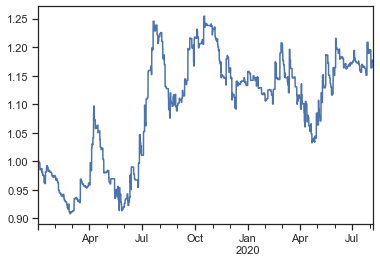

In [10]:
cumRet.plot()

In [11]:
pmdd

-0.3026960934879257

In [26]:
# maximize sum of Pessimistic Return on Margin and Maximum Drawdown

def objective(trial):
    slow = int(trial.suggest_discrete_uniform('slow', 1440, 4320, 240))
    fast = int(trial.suggest_discrete_uniform('fast', 60, 360, 15))
    mult = trial.suggest_discrete_uniform('mult', 1.3, 2.3, .1)
    return mean_reversion_strategy(df.loc['2019-02-15':'2019-08-15'].copy(), slow, fast, mult)[1]

In [27]:
study = optuna.create_study(direction='maximize')

In [28]:
study.optimize(objective, n_trials=100)

take profits: 6 
stopped out: 52 
time breaches: 119 
pos_ret: 25 
neg_ret: 52


[I 2020-08-08 21:16:28,740] Finished trial#0 with value: -0.632457119116729 with parameters: {'slow': 2880.0, 'fast': 120.0, 'mult': 1.9000000000000001}. Best is trial#0 with value: -0.632457119116729.


take profits: 5 
stopped out: 32 
time breaches: 84 
pos_ret: 19 
neg_ret: 33


[I 2020-08-08 21:16:29,933] Finished trial#1 with value: -0.35631300357243334 with parameters: {'slow': 2880.0, 'fast': 360.0, 'mult': 1.6}. Best is trial#1 with value: -0.35631300357243334.


take profits: 5 
stopped out: 55 
time breaches: 110 
pos_ret: 35 
neg_ret: 57


[I 2020-08-08 21:16:31,075] Finished trial#2 with value: -0.7000211789322408 with parameters: {'slow': 1440.0, 'fast': 150.0, 'mult': 2.1}. Best is trial#1 with value: -0.35631300357243334.


take profits: 3 
stopped out: 47 
time breaches: 88 
pos_ret: 25 
neg_ret: 49


[I 2020-08-08 21:16:32,303] Finished trial#3 with value: -0.6446146352449905 with parameters: {'slow': 1680.0, 'fast': 165.0, 'mult': 2.2}. Best is trial#1 with value: -0.35631300357243334.


take profits: 3 
stopped out: 40 
time breaches: 72 
pos_ret: 12 
neg_ret: 40


[I 2020-08-08 21:16:33,451] Finished trial#4 with value: -0.6569316820393081 with parameters: {'slow': 3360.0, 'fast': 195.0, 'mult': 2.1}. Best is trial#1 with value: -0.35631300357243334.


take profits: 7 
stopped out: 59 
time breaches: 140 
pos_ret: 26 
neg_ret: 59


[I 2020-08-08 21:16:34,643] Finished trial#5 with value: -0.6409722676756522 with parameters: {'slow': 3840.0, 'fast': 75.0, 'mult': 2.0}. Best is trial#1 with value: -0.35631300357243334.


take profits: 4 
stopped out: 42 
time breaches: 114 
pos_ret: 24 
neg_ret: 42


[I 2020-08-08 21:16:35,850] Finished trial#6 with value: -0.4830432014098638 with parameters: {'slow': 3360.0, 'fast': 225.0, 'mult': 1.5}. Best is trial#1 with value: -0.35631300357243334.


take profits: 4 
stopped out: 29 
time breaches: 72 
pos_ret: 14 
neg_ret: 29


[I 2020-08-08 21:16:37,039] Finished trial#7 with value: -0.3827039121668736 with parameters: {'slow': 3840.0, 'fast': 315.0, 'mult': 1.8}. Best is trial#1 with value: -0.35631300357243334.


take profits: 5 
stopped out: 62 
time breaches: 168 
pos_ret: 39 
neg_ret: 64


[I 2020-08-08 21:16:38,194] Finished trial#8 with value: -0.6670055617399961 with parameters: {'slow': 2160.0, 'fast': 195.0, 'mult': 1.5}. Best is trial#1 with value: -0.35631300357243334.


take profits: 1 
stopped out: 25 
time breaches: 35 
pos_ret: 5 
neg_ret: 25


[I 2020-08-08 21:16:39,424] Finished trial#9 with value: -0.4879159768902868 with parameters: {'slow': 2640.0, 'fast': 315.0, 'mult': 2.2}. Best is trial#1 with value: -0.35631300357243334.


take profits: 4 
stopped out: 27 
time breaches: 91 
pos_ret: 19 
neg_ret: 27


[I 2020-08-08 21:16:40,645] Finished trial#10 with value: -0.16382245707653603 with parameters: {'slow': 4320.0, 'fast': 345.0, 'mult': 1.3}. Best is trial#10 with value: -0.16382245707653603.


take profits: 4 
stopped out: 24 
time breaches: 88 
pos_ret: 18 
neg_ret: 24


[I 2020-08-08 21:16:41,902] Finished trial#11 with value: -0.13951694948586446 with parameters: {'slow': 4320.0, 'fast': 360.0, 'mult': 1.3}. Best is trial#11 with value: -0.13951694948586446.


take profits: 4 
stopped out: 24 
time breaches: 88 
pos_ret: 18 
neg_ret: 24


[I 2020-08-08 21:16:43,101] Finished trial#12 with value: -0.13951694948586446 with parameters: {'slow': 4320.0, 'fast': 360.0, 'mult': 1.3}. Best is trial#11 with value: -0.13951694948586446.


take profits: 8 
stopped out: 33 
time breaches: 97 
pos_ret: 21 
neg_ret: 33


[I 2020-08-08 21:16:44,415] Finished trial#13 with value: -0.19880389987019417 with parameters: {'slow': 4320.0, 'fast': 270.0, 'mult': 1.3}. Best is trial#11 with value: -0.13951694948586446.


take profits: 6 
stopped out: 27 
time breaches: 101 
pos_ret: 22 
neg_ret: 27


[I 2020-08-08 21:16:45,696] Finished trial#14 with value: -0.11273630612211877 with parameters: {'slow': 4080.0, 'fast': 270.0, 'mult': 1.3}. Best is trial#14 with value: -0.11273630612211877.


take profits: 4 
stopped out: 38 
time breaches: 96 
pos_ret: 20 
neg_ret: 38


[I 2020-08-08 21:16:46,972] Finished trial#15 with value: -0.4060181771598603 with parameters: {'slow': 3840.0, 'fast': 255.0, 'mult': 1.6}. Best is trial#14 with value: -0.11273630612211877.


take profits: 5 
stopped out: 34 
time breaches: 95 
pos_ret: 18 
neg_ret: 34


[I 2020-08-08 21:16:48,255] Finished trial#16 with value: -0.3254970771759108 with parameters: {'slow': 3600.0, 'fast': 285.0, 'mult': 1.4000000000000001}. Best is trial#14 with value: -0.11273630612211877.


take profits: 1 
stopped out: 32 
time breaches: 74 
pos_ret: 15 
neg_ret: 32


[I 2020-08-08 21:16:49,461] Finished trial#17 with value: -0.5188843060798334 with parameters: {'slow': 4320.0, 'fast': 315.0, 'mult': 1.7000000000000002}. Best is trial#14 with value: -0.11273630612211877.


take profits: 4 
stopped out: 34 
time breaches: 101 
pos_ret: 21 
neg_ret: 34


[I 2020-08-08 21:16:50,666] Finished trial#18 with value: -0.29297147556344916 with parameters: {'slow': 4080.0, 'fast': 240.0, 'mult': 1.4000000000000001}. Best is trial#14 with value: -0.11273630612211877.


take profits: 5 
stopped out: 38 
time breaches: 104 
pos_ret: 19 
neg_ret: 38


[I 2020-08-08 21:16:51,856] Finished trial#19 with value: -0.41373931027711264 with parameters: {'slow': 3360.0, 'fast': 285.0, 'mult': 1.4000000000000001}. Best is trial#14 with value: -0.11273630612211877.


take profits: 1 
stopped out: 29 
time breaches: 75 
pos_ret: 14 
neg_ret: 29


[I 2020-08-08 21:16:52,997] Finished trial#20 with value: -0.44033877438948776 with parameters: {'slow': 4080.0, 'fast': 330.0, 'mult': 1.7000000000000002}. Best is trial#14 with value: -0.11273630612211877.


take profits: 4 
stopped out: 24 
time breaches: 88 
pos_ret: 18 
neg_ret: 24


[I 2020-08-08 21:16:54,112] Finished trial#21 with value: -0.13951694948586446 with parameters: {'slow': 4320.0, 'fast': 360.0, 'mult': 1.3}. Best is trial#14 with value: -0.11273630612211877.


take profits: 7 
stopped out: 28 
time breaches: 90 
pos_ret: 22 
neg_ret: 28


[I 2020-08-08 21:16:55,231] Finished trial#22 with value: -0.10444639069373808 with parameters: {'slow': 4080.0, 'fast': 360.0, 'mult': 1.3}. Best is trial#22 with value: -0.10444639069373808.


take profits: 2 
stopped out: 40 
time breaches: 99 
pos_ret: 18 
neg_ret: 40


[I 2020-08-08 21:16:56,360] Finished trial#23 with value: -0.5804012540795236 with parameters: {'slow': 3600.0, 'fast': 300.0, 'mult': 1.5}. Best is trial#22 with value: -0.10444639069373808.


take profits: 3 
stopped out: 27 
time breaches: 79 
pos_ret: 16 
neg_ret: 27


[I 2020-08-08 21:16:57,522] Finished trial#24 with value: -0.367258165181257 with parameters: {'slow': 4080.0, 'fast': 360.0, 'mult': 1.4000000000000001}. Best is trial#22 with value: -0.10444639069373808.


take profits: 4 
stopped out: 31 
time breaches: 97 
pos_ret: 18 
neg_ret: 31


[I 2020-08-08 21:16:58,718] Finished trial#25 with value: -0.3399926713649245 with parameters: {'slow': 3600.0, 'fast': 330.0, 'mult': 1.3}. Best is trial#22 with value: -0.10444639069373808.


take profits: 6 
stopped out: 39 
time breaches: 104 
pos_ret: 24 
neg_ret: 39


[I 2020-08-08 21:16:59,935] Finished trial#26 with value: -0.4132457532373976 with parameters: {'slow': 3120.0, 'fast': 255.0, 'mult': 1.6}. Best is trial#22 with value: -0.10444639069373808.


take profits: 2 
stopped out: 31 
time breaches: 90 
pos_ret: 16 
neg_ret: 31


[I 2020-08-08 21:17:01,293] Finished trial#27 with value: -0.40248714401175634 with parameters: {'slow': 4080.0, 'fast': 285.0, 'mult': 1.4000000000000001}. Best is trial#22 with value: -0.10444639069373808.


take profits: 4 
stopped out: 35 
time breaches: 85 
pos_ret: 17 
neg_ret: 35


[I 2020-08-08 21:17:02,679] Finished trial#28 with value: -0.35879341006969456 with parameters: {'slow': 3840.0, 'fast': 345.0, 'mult': 1.5}. Best is trial#22 with value: -0.10444639069373808.


take profits: 6 
stopped out: 69 
time breaches: 263 
pos_ret: 68 
neg_ret: 71


[I 2020-08-08 21:17:03,984] Finished trial#29 with value: -0.38745138854736244 with parameters: {'slow': 2400.0, 'fast': 75.0, 'mult': 1.3}. Best is trial#22 with value: -0.10444639069373808.


take profits: 8 
stopped out: 55 
time breaches: 122 
pos_ret: 26 
neg_ret: 55


[I 2020-08-08 21:17:05,212] Finished trial#30 with value: -0.587199405555899 with parameters: {'slow': 3120.0, 'fast': 105.0, 'mult': 1.9000000000000001}. Best is trial#22 with value: -0.10444639069373808.


take profits: 4 
stopped out: 24 
time breaches: 88 
pos_ret: 18 
neg_ret: 24


[I 2020-08-08 21:17:06,353] Finished trial#31 with value: -0.13951694948586446 with parameters: {'slow': 4320.0, 'fast': 360.0, 'mult': 1.3}. Best is trial#22 with value: -0.10444639069373808.


take profits: 3 
stopped out: 29 
time breaches: 79 
pos_ret: 15 
neg_ret: 29


[I 2020-08-08 21:17:07,508] Finished trial#32 with value: -0.3987374696629775 with parameters: {'slow': 4080.0, 'fast': 345.0, 'mult': 1.4000000000000001}. Best is trial#22 with value: -0.10444639069373808.


take profits: 4 
stopped out: 24 
time breaches: 88 
pos_ret: 18 
neg_ret: 24


[I 2020-08-08 21:17:08,699] Finished trial#33 with value: -0.13951694948586446 with parameters: {'slow': 4320.0, 'fast': 360.0, 'mult': 1.3}. Best is trial#22 with value: -0.10444639069373808.


take profits: 5 
stopped out: 27 
time breaches: 82 
pos_ret: 18 
neg_ret: 27


[I 2020-08-08 21:17:09,860] Finished trial#34 with value: -0.19018682499849032 with parameters: {'slow': 4080.0, 'fast': 330.0, 'mult': 1.5}. Best is trial#22 with value: -0.10444639069373808.


take profits: 1 
stopped out: 31 
time breaches: 85 
pos_ret: 16 
neg_ret: 31


[I 2020-08-08 21:17:11,194] Finished trial#35 with value: -0.45715313100834604 with parameters: {'slow': 3840.0, 'fast': 300.0, 'mult': 1.4000000000000001}. Best is trial#22 with value: -0.10444639069373808.


take profits: 5 
stopped out: 45 
time breaches: 122 
pos_ret: 20 
neg_ret: 45


[I 2020-08-08 21:17:12,579] Finished trial#36 with value: -0.5949668015617395 with parameters: {'slow': 3600.0, 'fast': 150.0, 'mult': 1.6}. Best is trial#22 with value: -0.10444639069373808.


take profits: 7 
stopped out: 60 
time breaches: 209 
pos_ret: 52 
neg_ret: 66


[I 2020-08-08 21:17:13,894] Finished trial#37 with value: -0.5982810519797739 with parameters: {'slow': 1680.0, 'fast': 210.0, 'mult': 1.3}. Best is trial#22 with value: -0.10444639069373808.


take profits: 7 
stopped out: 25 
time breaches: 82 
pos_ret: 19 
neg_ret: 25


[I 2020-08-08 21:17:15,131] Finished trial#38 with value: -0.11161896909226489 with parameters: {'slow': 4320.0, 'fast': 345.0, 'mult': 1.4000000000000001}. Best is trial#22 with value: -0.10444639069373808.


take profits: 5 
stopped out: 39 
time breaches: 118 
pos_ret: 26 
neg_ret: 39


[I 2020-08-08 21:17:16,354] Finished trial#39 with value: -0.3551672629744492 with parameters: {'slow': 3840.0, 'fast': 180.0, 'mult': 1.4000000000000001}. Best is trial#22 with value: -0.10444639069373808.


take profits: 5 
stopped out: 29 
time breaches: 86 
pos_ret: 18 
neg_ret: 29


[I 2020-08-08 21:17:17,770] Finished trial#40 with value: -0.208558915351304 with parameters: {'slow': 4080.0, 'fast': 300.0, 'mult': 1.5}. Best is trial#22 with value: -0.10444639069373808.


take profits: 4 
stopped out: 27 
time breaches: 91 
pos_ret: 19 
neg_ret: 27


[I 2020-08-08 21:17:19,082] Finished trial#41 with value: -0.16382245707653603 with parameters: {'slow': 4320.0, 'fast': 345.0, 'mult': 1.3}. Best is trial#22 with value: -0.10444639069373808.


take profits: 2 
stopped out: 22 
time breaches: 33 
pos_ret: 8 
neg_ret: 22


[I 2020-08-08 21:17:20,377] Finished trial#42 with value: -0.3775613993585732 with parameters: {'slow': 4320.0, 'fast': 330.0, 'mult': 2.3}. Best is trial#22 with value: -0.10444639069373808.


take profits: 7 
stopped out: 28 
time breaches: 90 
pos_ret: 22 
neg_ret: 28


[I 2020-08-08 21:17:21,578] Finished trial#43 with value: -0.10444639069373808 with parameters: {'slow': 4080.0, 'fast': 360.0, 'mult': 1.3}. Best is trial#22 with value: -0.10444639069373808.


take profits: 2 
stopped out: 29 
time breaches: 84 
pos_ret: 16 
neg_ret: 29


[I 2020-08-08 21:17:22,867] Finished trial#44 with value: -0.38196562312941645 with parameters: {'slow': 3840.0, 'fast': 315.0, 'mult': 1.4000000000000001}. Best is trial#22 with value: -0.10444639069373808.


take profits: 6 
stopped out: 25 
time breaches: 91 
pos_ret: 22 
neg_ret: 25


[I 2020-08-08 21:17:24,061] Finished trial#45 with value: -0.07311899470257147 with parameters: {'slow': 4080.0, 'fast': 345.0, 'mult': 1.3}. Best is trial#45 with value: -0.07311899470257147.


take profits: 3 
stopped out: 36 
time breaches: 85 
pos_ret: 17 
neg_ret: 36


[I 2020-08-08 21:17:25,474] Finished trial#46 with value: -0.4600269390686922 with parameters: {'slow': 3600.0, 'fast': 345.0, 'mult': 1.5}. Best is trial#45 with value: -0.07311899470257147.


take profits: 4 
stopped out: 35 
time breaches: 113 
pos_ret: 26 
neg_ret: 35


[I 2020-08-08 21:17:26,825] Finished trial#47 with value: -0.3380969309219132 with parameters: {'slow': 3360.0, 'fast': 270.0, 'mult': 1.3}. Best is trial#45 with value: -0.07311899470257147.


take profits: 3 
stopped out: 38 
time breaches: 88 
pos_ret: 15 
neg_ret: 38


[I 2020-08-08 21:17:28,177] Finished trial#48 with value: -0.5493212789628792 with parameters: {'slow': 3840.0, 'fast': 225.0, 'mult': 1.7000000000000002}. Best is trial#45 with value: -0.07311899470257147.


take profits: 4 
stopped out: 28 
time breaches: 56 
pos_ret: 11 
neg_ret: 28


[I 2020-08-08 21:17:29,464] Finished trial#49 with value: -0.48193842032395817 with parameters: {'slow': 4080.0, 'fast': 315.0, 'mult': 2.0}. Best is trial#45 with value: -0.07311899470257147.


take profits: 3 
stopped out: 29 
time breaches: 83 
pos_ret: 17 
neg_ret: 29


[I 2020-08-08 21:17:31,001] Finished trial#50 with value: -0.3332120930967016 with parameters: {'slow': 3840.0, 'fast': 330.0, 'mult': 1.4000000000000001}. Best is trial#45 with value: -0.07311899470257147.


take profits: 4 
stopped out: 24 
time breaches: 88 
pos_ret: 18 
neg_ret: 24


[I 2020-08-08 21:17:32,252] Finished trial#51 with value: -0.13951694948586446 with parameters: {'slow': 4320.0, 'fast': 360.0, 'mult': 1.3}. Best is trial#45 with value: -0.07311899470257147.


take profits: 7 
stopped out: 28 
time breaches: 90 
pos_ret: 22 
neg_ret: 28


[I 2020-08-08 21:17:33,589] Finished trial#52 with value: -0.10444639069373808 with parameters: {'slow': 4080.0, 'fast': 360.0, 'mult': 1.3}. Best is trial#45 with value: -0.07311899470257147.


take profits: 3 
stopped out: 29 
time breaches: 79 
pos_ret: 15 
neg_ret: 29


[I 2020-08-08 21:17:35,235] Finished trial#53 with value: -0.3987374696629775 with parameters: {'slow': 4080.0, 'fast': 345.0, 'mult': 1.4000000000000001}. Best is trial#45 with value: -0.07311899470257147.


take profits: 7 
stopped out: 25 
time breaches: 92 
pos_ret: 23 
neg_ret: 25


[I 2020-08-08 21:17:37,020] Finished trial#54 with value: -0.011172430947941049 with parameters: {'slow': 4080.0, 'fast': 315.0, 'mult': 1.3}. Best is trial#54 with value: -0.011172430947941049.


take profits: 7 
stopped out: 31 
time breaches: 98 
pos_ret: 23 
neg_ret: 31


[I 2020-08-08 21:17:38,289] Finished trial#55 with value: -0.16004334206292659 with parameters: {'slow': 3840.0, 'fast': 345.0, 'mult': 1.3}. Best is trial#54 with value: -0.011172430947941049.


take profits: 3 
stopped out: 27 
time breaches: 79 
pos_ret: 16 
neg_ret: 27


[I 2020-08-08 21:17:39,650] Finished trial#56 with value: -0.367258165181257 with parameters: {'slow': 4080.0, 'fast': 360.0, 'mult': 1.4000000000000001}. Best is trial#54 with value: -0.011172430947941049.


take profits: 4 
stopped out: 31 
time breaches: 97 
pos_ret: 18 
neg_ret: 31


[I 2020-08-08 21:17:40,971] Finished trial#57 with value: -0.3399926713649245 with parameters: {'slow': 3600.0, 'fast': 330.0, 'mult': 1.3}. Best is trial#54 with value: -0.011172430947941049.


take profits: 7 
stopped out: 27 
time breaches: 98 
pos_ret: 23 
neg_ret: 27


[I 2020-08-08 21:17:42,246] Finished trial#58 with value: -0.08033850768520194 with parameters: {'slow': 4320.0, 'fast': 300.0, 'mult': 1.3}. Best is trial#54 with value: -0.011172430947941049.


take profits: 4 
stopped out: 31 
time breaches: 106 
pos_ret: 25 
neg_ret: 31


[I 2020-08-08 21:17:43,554] Finished trial#59 with value: -0.2802544359694258 with parameters: {'slow': 3360.0, 'fast': 300.0, 'mult': 1.3}. Best is trial#54 with value: -0.011172430947941049.


take profits: 7 
stopped out: 25 
time breaches: 92 
pos_ret: 23 
neg_ret: 25


[I 2020-08-08 21:17:44,869] Finished trial#60 with value: -0.011172430947941049 with parameters: {'slow': 4080.0, 'fast': 315.0, 'mult': 1.3}. Best is trial#54 with value: -0.011172430947941049.


take profits: 7 
stopped out: 25 
time breaches: 92 
pos_ret: 23 
neg_ret: 25


[I 2020-08-08 21:17:46,206] Finished trial#61 with value: -0.011172430947941049 with parameters: {'slow': 4080.0, 'fast': 315.0, 'mult': 1.3}. Best is trial#54 with value: -0.011172430947941049.


take profits: 6 
stopped out: 32 
time breaches: 103 
pos_ret: 23 
neg_ret: 32


[I 2020-08-08 21:17:47,421] Finished trial#62 with value: -0.21472609577443028 with parameters: {'slow': 3840.0, 'fast': 315.0, 'mult': 1.3}. Best is trial#54 with value: -0.011172430947941049.


take profits: 2 
stopped out: 31 
time breaches: 90 
pos_ret: 16 
neg_ret: 31


[I 2020-08-08 21:17:48,666] Finished trial#63 with value: -0.40248714401175634 with parameters: {'slow': 4080.0, 'fast': 285.0, 'mult': 1.4000000000000001}. Best is trial#54 with value: -0.011172430947941049.


take profits: 7 
stopped out: 27 
time breaches: 98 
pos_ret: 23 
neg_ret: 27


[I 2020-08-08 21:17:49,967] Finished trial#64 with value: -0.08033850768520194 with parameters: {'slow': 4320.0, 'fast': 300.0, 'mult': 1.3}. Best is trial#54 with value: -0.011172430947941049.


take profits: 8 
stopped out: 31 
time breaches: 85 
pos_ret: 20 
neg_ret: 31


[I 2020-08-08 21:17:51,211] Finished trial#65 with value: -0.1705846940286598 with parameters: {'slow': 4320.0, 'fast': 300.0, 'mult': 1.4000000000000001}. Best is trial#54 with value: -0.011172430947941049.


take profits: 2 
stopped out: 32 
time breaches: 85 
pos_ret: 15 
neg_ret: 32


[I 2020-08-08 21:17:52,448] Finished trial#66 with value: -0.3975347643140773 with parameters: {'slow': 4320.0, 'fast': 285.0, 'mult': 1.5}. Best is trial#54 with value: -0.011172430947941049.


take profits: 8 
stopped out: 32 
time breaches: 105 
pos_ret: 23 
neg_ret: 32


[I 2020-08-08 21:17:53,750] Finished trial#67 with value: -0.15817306407192624 with parameters: {'slow': 4320.0, 'fast': 255.0, 'mult': 1.3}. Best is trial#54 with value: -0.011172430947941049.


take profits: 6 
stopped out: 27 
time breaches: 101 
pos_ret: 22 
neg_ret: 27


[I 2020-08-08 21:17:55,025] Finished trial#68 with value: -0.11273630612211877 with parameters: {'slow': 4080.0, 'fast': 270.0, 'mult': 1.3}. Best is trial#54 with value: -0.011172430947941049.


take profits: 1 
stopped out: 31 
time breaches: 85 
pos_ret: 16 
neg_ret: 31


[I 2020-08-08 21:17:56,465] Finished trial#69 with value: -0.45715313100834604 with parameters: {'slow': 3840.0, 'fast': 300.0, 'mult': 1.4000000000000001}. Best is trial#54 with value: -0.011172430947941049.


take profits: 8 
stopped out: 51 
time breaches: 138 
pos_ret: 40 
neg_ret: 52


[I 2020-08-08 21:17:57,921] Finished trial#70 with value: -0.3199033056390639 with parameters: {'slow': 2160.0, 'fast': 315.0, 'mult': 1.4000000000000001}. Best is trial#54 with value: -0.011172430947941049.


take profits: 9 
stopped out: 27 
time breaches: 91 
pos_ret: 25 
neg_ret: 27


[I 2020-08-08 21:17:59,394] Finished trial#71 with value: -0.002023423323469789 with parameters: {'slow': 4080.0, 'fast': 330.0, 'mult': 1.3}. Best is trial#71 with value: -0.002023423323469789.


take profits: 7 
stopped out: 25 
time breaches: 92 
pos_ret: 23 
neg_ret: 25


[I 2020-08-08 21:18:01,019] Finished trial#72 with value: -0.011172430947941049 with parameters: {'slow': 4080.0, 'fast': 315.0, 'mult': 1.3}. Best is trial#71 with value: -0.002023423323469789.


take profits: 7 
stopped out: 26 
time breaches: 93 
pos_ret: 21 
neg_ret: 26


[I 2020-08-08 21:18:02,296] Finished trial#73 with value: -0.08970090608662781 with parameters: {'slow': 4320.0, 'fast': 315.0, 'mult': 1.3}. Best is trial#71 with value: -0.002023423323469789.


take profits: 7 
stopped out: 31 
time breaches: 100 
pos_ret: 23 
neg_ret: 31


[I 2020-08-08 21:18:03,584] Finished trial#74 with value: -0.15651383764132565 with parameters: {'slow': 3840.0, 'fast': 330.0, 'mult': 1.3}. Best is trial#71 with value: -0.002023423323469789.


take profits: 5 
stopped out: 26 
time breaches: 80 
pos_ret: 17 
neg_ret: 26


[I 2020-08-08 21:18:05,027] Finished trial#75 with value: -0.2262135010346218 with parameters: {'slow': 4080.0, 'fast': 315.0, 'mult': 1.4000000000000001}. Best is trial#71 with value: -0.002023423323469789.


take profits: 3 
stopped out: 33 
time breaches: 79 
pos_ret: 13 
neg_ret: 33


[I 2020-08-08 21:18:06,336] Finished trial#76 with value: -0.5318415457125392 with parameters: {'slow': 4320.0, 'fast': 285.0, 'mult': 1.8}. Best is trial#71 with value: -0.002023423323469789.


take profits: 6 
stopped out: 27 
time breaches: 101 
pos_ret: 22 
neg_ret: 27


[I 2020-08-08 21:18:07,624] Finished trial#77 with value: -0.11273630612211877 with parameters: {'slow': 4080.0, 'fast': 270.0, 'mult': 1.3}. Best is trial#71 with value: -0.002023423323469789.


take profits: 4 
stopped out: 26 
time breaches: 79 
pos_ret: 14 
neg_ret: 27


[I 2020-08-08 21:18:09,053] Finished trial#78 with value: -0.2571103762460326 with parameters: {'slow': 4080.0, 'fast': 330.0, 'mult': 1.4000000000000001}. Best is trial#71 with value: -0.002023423323469789.


take profits: 7 
stopped out: 27 
time breaches: 98 
pos_ret: 23 
neg_ret: 27


[I 2020-08-08 21:18:10,352] Finished trial#79 with value: -0.08033850768520194 with parameters: {'slow': 4320.0, 'fast': 300.0, 'mult': 1.3}. Best is trial#71 with value: -0.002023423323469789.


take profits: 5 
stopped out: 37 
time breaches: 96 
pos_ret: 22 
neg_ret: 37


[I 2020-08-08 21:18:11,693] Finished trial#80 with value: -0.29484978332255585 with parameters: {'slow': 3600.0, 'fast': 315.0, 'mult': 1.5}. Best is trial#71 with value: -0.002023423323469789.


take profits: 7 
stopped out: 27 
time breaches: 98 
pos_ret: 23 
neg_ret: 27


[I 2020-08-08 21:18:12,924] Finished trial#81 with value: -0.08033850768520194 with parameters: {'slow': 4320.0, 'fast': 300.0, 'mult': 1.3}. Best is trial#71 with value: -0.002023423323469789.


take profits: 7 
stopped out: 32 
time breaches: 98 
pos_ret: 21 
neg_ret: 32


[I 2020-08-08 21:18:14,238] Finished trial#82 with value: -0.18858941488814907 with parameters: {'slow': 4320.0, 'fast': 285.0, 'mult': 1.3}. Best is trial#71 with value: -0.002023423323469789.


take profits: 6 
stopped out: 29 
time breaches: 94 
pos_ret: 21 
neg_ret: 29


[I 2020-08-08 21:18:15,585] Finished trial#83 with value: -0.18758734735195592 with parameters: {'slow': 4080.0, 'fast': 300.0, 'mult': 1.3}. Best is trial#71 with value: -0.002023423323469789.


take profits: 7 
stopped out: 31 
time breaches: 100 
pos_ret: 23 
neg_ret: 31


[I 2020-08-08 21:18:16,900] Finished trial#84 with value: -0.15651383764132565 with parameters: {'slow': 3840.0, 'fast': 330.0, 'mult': 1.3}. Best is trial#71 with value: -0.002023423323469789.


take profits: 5 
stopped out: 32 
time breaches: 82 
pos_ret: 16 
neg_ret: 32


[I 2020-08-08 21:18:18,317] Finished trial#85 with value: -0.32657680680405826 with parameters: {'slow': 4320.0, 'fast': 315.0, 'mult': 1.4000000000000001}. Best is trial#71 with value: -0.002023423323469789.


take profits: 6 
stopped out: 29 
time breaches: 94 
pos_ret: 21 
neg_ret: 29


[I 2020-08-08 21:18:19,711] Finished trial#86 with value: -0.18758734735195592 with parameters: {'slow': 4080.0, 'fast': 300.0, 'mult': 1.3}. Best is trial#71 with value: -0.002023423323469789.


take profits: 6 
stopped out: 84 
time breaches: 285 
pos_ret: 68 
neg_ret: 86


[I 2020-08-08 21:18:21,039] Finished trial#87 with value: -0.7433515557417787 with parameters: {'slow': 2640.0, 'fast': 60.0, 'mult': 1.3}. Best is trial#71 with value: -0.002023423323469789.


take profits: 3 
stopped out: 31 
time breaches: 90 
pos_ret: 16 
neg_ret: 31


[I 2020-08-08 21:18:22,297] Finished trial#88 with value: -0.4032716721351266 with parameters: {'slow': 4320.0, 'fast': 270.0, 'mult': 1.4000000000000001}. Best is trial#71 with value: -0.002023423323469789.


take profits: 6 
stopped out: 25 
time breaches: 91 
pos_ret: 22 
neg_ret: 25


[I 2020-08-08 21:18:23,606] Finished trial#89 with value: -0.07311899470257147 with parameters: {'slow': 4080.0, 'fast': 345.0, 'mult': 1.3}. Best is trial#71 with value: -0.002023423323469789.


take profits: 3 
stopped out: 29 
time breaches: 81 
pos_ret: 16 
neg_ret: 29


[I 2020-08-08 21:18:25,034] Finished trial#90 with value: -0.33994909210166374 with parameters: {'slow': 3840.0, 'fast': 345.0, 'mult': 1.4000000000000001}. Best is trial#71 with value: -0.002023423323469789.


take profits: 9 
stopped out: 27 
time breaches: 91 
pos_ret: 25 
neg_ret: 27


[I 2020-08-08 21:18:26,469] Finished trial#91 with value: -0.002023423323469789 with parameters: {'slow': 4080.0, 'fast': 330.0, 'mult': 1.3}. Best is trial#71 with value: -0.002023423323469789.


take profits: 9 
stopped out: 27 
time breaches: 91 
pos_ret: 25 
neg_ret: 27


[I 2020-08-08 21:18:27,819] Finished trial#92 with value: -0.002023423323469789 with parameters: {'slow': 4080.0, 'fast': 330.0, 'mult': 1.3}. Best is trial#71 with value: -0.002023423323469789.


take profits: 9 
stopped out: 27 
time breaches: 91 
pos_ret: 25 
neg_ret: 27


[I 2020-08-08 21:18:29,188] Finished trial#93 with value: -0.002023423323469789 with parameters: {'slow': 4080.0, 'fast': 330.0, 'mult': 1.3}. Best is trial#71 with value: -0.002023423323469789.


take profits: 9 
stopped out: 27 
time breaches: 91 
pos_ret: 25 
neg_ret: 27


[I 2020-08-08 21:18:30,492] Finished trial#94 with value: -0.002023423323469789 with parameters: {'slow': 4080.0, 'fast': 330.0, 'mult': 1.3}. Best is trial#71 with value: -0.002023423323469789.


take profits: 7 
stopped out: 31 
time breaches: 100 
pos_ret: 23 
neg_ret: 31


[I 2020-08-08 21:18:31,799] Finished trial#95 with value: -0.15651383764132565 with parameters: {'slow': 3840.0, 'fast': 330.0, 'mult': 1.3}. Best is trial#71 with value: -0.002023423323469789.


take profits: 4 
stopped out: 26 
time breaches: 79 
pos_ret: 14 
neg_ret: 27


[I 2020-08-08 21:18:33,138] Finished trial#96 with value: -0.2571103762460326 with parameters: {'slow': 4080.0, 'fast': 330.0, 'mult': 1.4000000000000001}. Best is trial#71 with value: -0.002023423323469789.


take profits: 7 
stopped out: 31 
time breaches: 98 
pos_ret: 23 
neg_ret: 31


[I 2020-08-08 21:18:34,494] Finished trial#97 with value: -0.16004334206292659 with parameters: {'slow': 3840.0, 'fast': 345.0, 'mult': 1.3}. Best is trial#71 with value: -0.002023423323469789.


take profits: 5 
stopped out: 26 
time breaches: 80 
pos_ret: 17 
neg_ret: 26


[I 2020-08-08 21:18:35,881] Finished trial#98 with value: -0.2262135010346218 with parameters: {'slow': 4080.0, 'fast': 315.0, 'mult': 1.4000000000000001}. Best is trial#71 with value: -0.002023423323469789.


take profits: 1 
stopped out: 24 
time breaches: 40 
pos_ret: 8 
neg_ret: 24


[I 2020-08-08 21:18:37,158] Finished trial#99 with value: -0.5035813391200848 with parameters: {'slow': 4080.0, 'fast': 330.0, 'mult': 2.2}. Best is trial#71 with value: -0.002023423323469789.


In [29]:
study.best_params

{'slow': 4080.0, 'fast': 330.0, 'mult': 1.3}

In [33]:
study.best_value

-0.002023423323469789

In [37]:
cumRet, pmdd = mean_reversion_strategy(df.loc['2019-02-15':'2019-08-15'].copy(), 4080, 330, 1.3)

take profits: 9 
stopped out: 27 
time breaches: 91 
pos_ret: 25 
neg_ret: 27


The performance looks promising. This is the overfitted performance, so it serves little purpose other than showing the merit of exploring this strategy further. 

The next step would be to run this strategy through a Walk-Forward Analysis or Combinatorial Purged Cross Validation process. This is not done here; please refer to those notebooks for more details. 

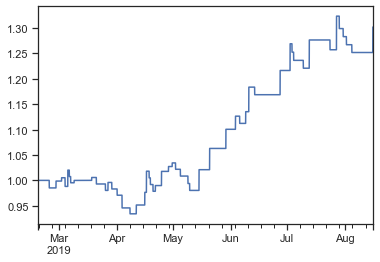

In [38]:
cumRet.plot()